In [27]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from torchvision.transforms.functional import to_pil_image
from torchvision import models, transforms

from fastai.callbacks import hook_outputs
from fastai.torch_core import requires_grad, children

In [3]:
# check if training using GPU is possible
torch.cuda.is_available()

True

In [12]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
# folder, created in advance in the Google Drive and containing kaggle.json
#project_folder = "/content/gdrive/My Drive/Kaggle/NaturalPainters" # for original email
project_folder = "/content/gdrive/My Drive/NaturalPainters" 
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [14]:
# dive into folder
#%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters


# **GAN**

In [17]:
# data is stored in the 'episodes_i.npz' format, where i is in {0,...,77}
# this routine loads desired 'episodes_i.npz' for a particular i
# data will be loaded in the dictionary with two fields: 'strokes' and 'actions'
def load_data(npz):

    data = np.load('strokes-dataset/' + npz)
    return data['strokes'], data['actions']

In [20]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
      super(Generator, self).__init__()

      self.out_features = img_height * img_width

      self.lin = nn.Linear(in_features, self.out_features)

      self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                      kernel_size = (4, 4), stride = (1, 1), bias = False)
      self.norm1 = nn.BatchNorm2d(num_features)

      self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm2 = nn.BatchNorm2d(num_features)

      self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm3 = nn.BatchNorm2d(num_features)

      self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm4 = nn.BatchNorm2d(num_features)

      self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                      kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
      self.norm5 = nn.BatchNorm2d(num_features)

      self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
      x = self.lin(x)
      x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
      x = self.norm1(x)
      x = F.relu(self.conv2(x), inplace = True)
      x = self.norm2(x)
      x = F.relu(self.conv3(x), inplace = True)
      x = self.norm3(x)
      x = F.relu(self.conv4(x), inplace = True)
      x = self.norm4(x)
      x = F.relu(self.conv5(x), inplace = True)
      x = self.norm5(x)

      return torch.tanh(self.conv6(x))

In [22]:
class FeatureExtractor(nn.Module):

    def __init__(self, 
                 layers_weights,
                 device):
      super(FeatureExtractor, self).__init__()
      
      self.layers_weights = layers_weights
      self.device = device
      self.feature_extractor, self.layers_indices = self.extractor()
      self.outputs = hook_outputs([self.feature_extractor[i] for i in self.layers_indices], detach = False)

    def extractor(self):
        print("Download VGG19 (batch normalized) as pre-trained.")
        if device == 'cuda':
            extractor = models.vgg19_bn(True).features.cuda().eval()
        else:
            extractor = models.vgg19_bn(True).features.eval()
        requires_grad(extractor, False)
        return extractor, [i - 1 for i, layer in enumerate(children(extractor)) if isinstance(layer, nn.MaxPool2d)][2:]

    def gram_matrix(self, input):

        (a, b, c, d) = input.size()
        features = input.view(a, b, c * d)
        G = features @ features.transpose(1, 2)
        return G.div(b * c * d)

    def forward(self, gen_stroke, true_stroke):

        self.feature_extractor(gen_stroke)
        gen_stroke_features = [out for out in self.outputs.stored]
        
        self.feature_extractor(true_stroke)
        true_stroke_features = [out.clone() for out in self.outputs.stored]

        self.loss = []
        
        feature_loss = [F.l1_loss(gen_layer, true_layer) * weight
                             for gen_layer, true_layer, weight 
                        in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
        

        style_loss = [F.l1_loss(self.gram_matrix(gen_layer), self.gram_matrix(true_layer)) * weight**2 * 5000
                             for gen_layer, true_layer, weight 
                      in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
    
        pixel_loss = [F.l1_loss(gen_stroke, true_stroke)]

        self.loss += feature_loss + style_loss + pixel_loss
                
        return sum(self.loss)

    def __del__(self):
        
        self.outputs.remove()

In [19]:
class Discriminator(nn.Module):
  def __init__(self, 
               img_channels: int, 
               num_features: int):
    super(Discriminator, self).__init__()

    self.conv1 = nn.Conv2d(img_channels, num_features, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.conv2 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm2 = nn.BatchNorm2d(num_features)
    self.conv3 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm3 = nn.BatchNorm2d(num_features)
    self.conv4 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.norm4 = nn.BatchNorm2d(num_features*2)
    self.lin = nn.Linear(4*4*(num_features*2), 1)


  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), negative_slope = 0.2)
    x = F.leaky_relu(self.norm2(self.conv2(x)), negative_slope = 0.2)
    x = F.leaky_relu(self.norm3(self.conv3(x)), negative_slope = 0.2)
    x = F.leaky_relu(self.norm4(self.conv4(x)), negative_slope = 0.2)
    x = x.flatten(start_dim = 1)

    return self.lin(x)

In [23]:
strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: x.float()),
                                   transforms.Lambda(lambda x: x.div_(255))
                                  ])

In [31]:
torch.manual_seed(4)
class Trainer():

    def __init__(self,
                 transforms,
                 generator: nn.Module,
                 feature_extractor: nn.Module,
                 discriminator: nn.Module,
                 g_optimizer: torch.optim,
                 d_optimizer: torch.optim,
                 loss: torch.nn.functional,
                 epochs: int = 5,
                 gpu: bool = False):
            super(Trainer, self).__init__()

            self.transforms = transforms
            self.generator = generator
            self.feature_extractor = feature_extractor
            self.discriminator = discriminator
            self.g_optimizer = g_optimizer
            self.d_optimizer = d_optimizer
            self.loss = loss
            self.epochs = epochs
            self.gpu = gpu

    def train(self,
              dataloader,
              print_interval: int = 50):

        d_train_loss = []
        g_train_loss = []


        for epoch in range(self.epochs):
            
            self.generator.train()
            self.discriminator.train()
          
            epoch_start_time = time.time()

            for i, (stroke, action) in enumerate(dataloader):  

                stroke = torch.stack([self.transforms(s) for s in stroke])
                
                y_true = torch.ones((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)   
                y_gen = torch.zeros((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)

                if gpu:
                  action = action.cuda()
                  stroke = stroke.cuda()
                  y_true = y_true.cuda()
                  y_gen = y_gen.cuda()

                # Discriminator part

                self.d_optimizer.zero_grad()

                y_true_pred = torch.sigmoid(self.discriminator(stroke))
                true_loss = self.loss(y_true_pred, y_true)

                gen_stroke = self.generator(action)
                d_y_gen_pred = torch.sigmoid(self.discriminator(gen_stroke))
                gen_loss = self.loss(d_y_gen_pred, y_gen)

                d_cur_loss = 0.5 * true_loss + 0.5 * gen_loss

                d_cur_loss.backward()
                self.d_optimizer.step()

                d_train_loss.append(d_cur_loss.data.item())

                # Generator part

                self.g_optimizer.zero_grad()

                gen_stroke = self.generator(action)
                g_y_gen_pred = torch.sigmoid(self.discriminator(gen_stroke))

                g_cur_loss = 0.5 * self.loss(g_y_gen_pred, y_true) + 0.5 * self.feature_extractor(gen_stroke, stroke)

                g_cur_loss.backward()
                self.g_optimizer.step()

                g_train_loss.append(g_cur_loss.data.item())


                if (i % print_interval) == 0:
                    print('Epoch {}/{} | Sample {}/{}'.format((epoch + 1), self.epochs,
                                                              (i + 1), len(dataloader)))
                    
                    print(' => Loss: 1) discriminator - {:.3f}, 2) generator - {:.3f}'.format(torch.mean(torch.FloatTensor(d_train_loss)),
                                                                                              torch.mean(torch.FloatTensor(g_train_loss))))

                    s = stroke[0].clone().cpu()
                    print('true stroke')
                    print('discriminator prediction for true = 1:', round(y_true_pred[0].item(), 3))
                    display(to_pil_image(s))
                    print('-'*25)

                    g = gen_stroke[0].clone().cpu()
                    print('generated stroke')
                    print('discriminator prediction for true = 0:', round(g_y_gen_pred[0].item(), 3))
                    display(to_pil_image(g))
                    print('-'*55)
            
            print('-'*100)
            epoch_time = time.time()- epoch_start_time
            print('End of epoch {}/{} - time: {:.3f}, => Loss of generator: {:.3f}\n'.format((epoch + 1), self.epochs,
                                                                                           epoch_time,
            print('-'*100)                                                                               torch.mean(torch.FloatTensor(g_train_loss))))



        torch.save(generator.state_dict(), project_folder + 'GAN_generator_5e.pth')   
        torch.save(discriminator.state_dict(), project_folder + 'GAN_discriminator_5e.pth')         

Download VGG19 (batch normalized) as pre-trained.
Training is performed using GPU.

Epoch 1/5 | Sample 1/391
 => Loss: 1) discriminator - 0.000, 2) generator - 6.791
true stroke
discriminator prediction for true = 1: 1.0


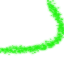

-------------------------
generated stroke
discriminator prediction for true = 0: 0.0


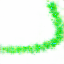

--------------------------------------------------
Epoch 1/5 | Sample 26/391
 => Loss: 1) discriminator - 0.150, 2) generator - 4.150
true stroke
discriminator prediction for true = 1: 0.993


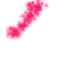

-------------------------
generated stroke
discriminator prediction for true = 0: 0.003


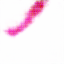

--------------------------------------------------
Epoch 1/5 | Sample 51/391
 => Loss: 1) discriminator - 0.283, 2) generator - 3.318
true stroke
discriminator prediction for true = 1: 0.583


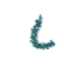

-------------------------
generated stroke
discriminator prediction for true = 0: 0.024


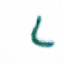

--------------------------------------------------
Epoch 1/5 | Sample 76/391
 => Loss: 1) discriminator - 0.405, 2) generator - 2.774
true stroke
discriminator prediction for true = 1: 0.762


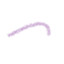

-------------------------
generated stroke
discriminator prediction for true = 0: 0.541


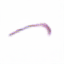

--------------------------------------------------
Epoch 1/5 | Sample 101/391
 => Loss: 1) discriminator - 0.468, 2) generator - 2.460
true stroke
discriminator prediction for true = 1: 0.616


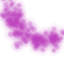

-------------------------
generated stroke
discriminator prediction for true = 0: 0.425


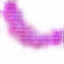

--------------------------------------------------
Epoch 1/5 | Sample 126/391
 => Loss: 1) discriminator - 0.494, 2) generator - 2.265
true stroke
discriminator prediction for true = 1: 0.339


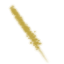

-------------------------
generated stroke
discriminator prediction for true = 0: 0.521


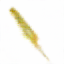

--------------------------------------------------
Epoch 1/5 | Sample 151/391
 => Loss: 1) discriminator - 0.509, 2) generator - 2.146
true stroke
discriminator prediction for true = 1: 0.717


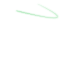

-------------------------
generated stroke
discriminator prediction for true = 0: 0.328


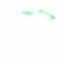

--------------------------------------------------
Epoch 1/5 | Sample 176/391
 => Loss: 1) discriminator - 0.525, 2) generator - 2.052
true stroke
discriminator prediction for true = 1: 0.549


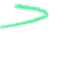

-------------------------
generated stroke
discriminator prediction for true = 0: 0.177


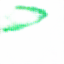

--------------------------------------------------
Epoch 1/5 | Sample 201/391
 => Loss: 1) discriminator - 0.526, 2) generator - 1.991
true stroke
discriminator prediction for true = 1: 0.848


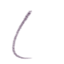

-------------------------
generated stroke
discriminator prediction for true = 0: 0.101


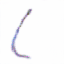

--------------------------------------------------
Epoch 1/5 | Sample 226/391
 => Loss: 1) discriminator - 0.530, 2) generator - 1.946
true stroke
discriminator prediction for true = 1: 0.177


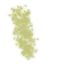

-------------------------
generated stroke
discriminator prediction for true = 0: 0.237


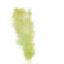

--------------------------------------------------
Epoch 1/5 | Sample 251/391
 => Loss: 1) discriminator - 0.531, 2) generator - 1.910
true stroke
discriminator prediction for true = 1: 0.547


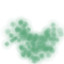

-------------------------
generated stroke
discriminator prediction for true = 0: 0.127


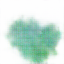

--------------------------------------------------
Epoch 1/5 | Sample 276/391
 => Loss: 1) discriminator - 0.531, 2) generator - 1.882
true stroke
discriminator prediction for true = 1: 0.534


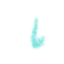

-------------------------
generated stroke
discriminator prediction for true = 0: 0.553


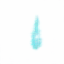

--------------------------------------------------
Epoch 1/5 | Sample 301/391
 => Loss: 1) discriminator - 0.530, 2) generator - 1.864
true stroke
discriminator prediction for true = 1: 0.736


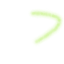

-------------------------
generated stroke
discriminator prediction for true = 0: 0.246


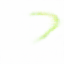

--------------------------------------------------
Epoch 1/5 | Sample 326/391
 => Loss: 1) discriminator - 0.526, 2) generator - 1.849
true stroke
discriminator prediction for true = 1: 0.625


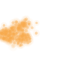

-------------------------
generated stroke
discriminator prediction for true = 0: 0.237


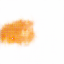

--------------------------------------------------
Epoch 1/5 | Sample 351/391
 => Loss: 1) discriminator - 0.527, 2) generator - 1.835
true stroke
discriminator prediction for true = 1: 0.907


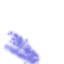

-------------------------
generated stroke
discriminator prediction for true = 0: 0.223


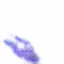

--------------------------------------------------
Epoch 1/5 | Sample 376/391
 => Loss: 1) discriminator - 0.522, 2) generator - 1.826
true stroke
discriminator prediction for true = 1: 0.908


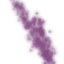

-------------------------
generated stroke
discriminator prediction for true = 0: 0.303


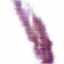

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 1/5 - time: 480.760, => Loss of generator: 1.818
Epoch 2/5 | Sample 1/391
 => Loss: 1) discriminator - 0.523, 2) generator - 1.818
true stroke
discriminator prediction for true = 1: 0.899


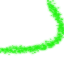

-------------------------
generated stroke
discriminator prediction for true = 0: 0.714


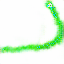

--------------------------------------------------
Epoch 2/5 | Sample 26/391
 => Loss: 1) discriminator - 0.519, 2) generator - 1.814
true stroke
discriminator prediction for true = 1: 0.711


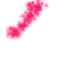

-------------------------
generated stroke
discriminator prediction for true = 0: 0.345


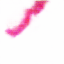

--------------------------------------------------
Epoch 2/5 | Sample 51/391
 => Loss: 1) discriminator - 0.516, 2) generator - 1.808
true stroke
discriminator prediction for true = 1: 0.805


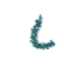

-------------------------
generated stroke
discriminator prediction for true = 0: 0.113


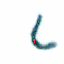

--------------------------------------------------
Epoch 2/5 | Sample 76/391
 => Loss: 1) discriminator - 0.515, 2) generator - 1.803
true stroke
discriminator prediction for true = 1: 0.477


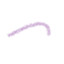

-------------------------
generated stroke
discriminator prediction for true = 0: 0.345


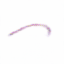

--------------------------------------------------
Epoch 2/5 | Sample 101/391
 => Loss: 1) discriminator - 0.513, 2) generator - 1.799
true stroke
discriminator prediction for true = 1: 0.97


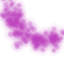

-------------------------
generated stroke
discriminator prediction for true = 0: 0.29


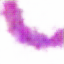

--------------------------------------------------
Epoch 2/5 | Sample 126/391
 => Loss: 1) discriminator - 0.510, 2) generator - 1.796
true stroke
discriminator prediction for true = 1: 0.411


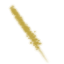

-------------------------
generated stroke
discriminator prediction for true = 0: 0.135


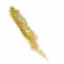

--------------------------------------------------
Epoch 2/5 | Sample 151/391
 => Loss: 1) discriminator - 0.508, 2) generator - 1.794
true stroke
discriminator prediction for true = 1: 0.885


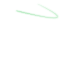

-------------------------
generated stroke
discriminator prediction for true = 0: 0.05


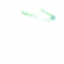

--------------------------------------------------
Epoch 2/5 | Sample 176/391
 => Loss: 1) discriminator - 0.506, 2) generator - 1.793
true stroke
discriminator prediction for true = 1: 0.933


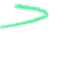

-------------------------
generated stroke
discriminator prediction for true = 0: 0.06


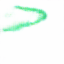

--------------------------------------------------
Epoch 2/5 | Sample 201/391
 => Loss: 1) discriminator - 0.504, 2) generator - 1.793
true stroke
discriminator prediction for true = 1: 0.889


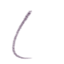

-------------------------
generated stroke
discriminator prediction for true = 0: 0.081


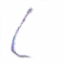

--------------------------------------------------
Epoch 2/5 | Sample 226/391
 => Loss: 1) discriminator - 0.502, 2) generator - 1.793
true stroke
discriminator prediction for true = 1: 0.525


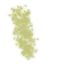

-------------------------
generated stroke
discriminator prediction for true = 0: 0.14


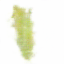

--------------------------------------------------
Epoch 2/5 | Sample 251/391
 => Loss: 1) discriminator - 0.498, 2) generator - 1.795
true stroke
discriminator prediction for true = 1: 0.967


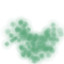

-------------------------
generated stroke
discriminator prediction for true = 0: 0.001


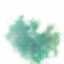

--------------------------------------------------
Epoch 2/5 | Sample 276/391
 => Loss: 1) discriminator - 0.496, 2) generator - 1.796
true stroke
discriminator prediction for true = 1: 0.877


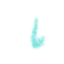

-------------------------
generated stroke
discriminator prediction for true = 0: 0.193


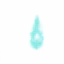

--------------------------------------------------
Epoch 2/5 | Sample 301/391
 => Loss: 1) discriminator - 0.493, 2) generator - 1.798
true stroke
discriminator prediction for true = 1: 0.609


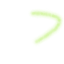

-------------------------
generated stroke
discriminator prediction for true = 0: 0.342


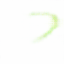

--------------------------------------------------
Epoch 2/5 | Sample 326/391
 => Loss: 1) discriminator - 0.491, 2) generator - 1.801
true stroke
discriminator prediction for true = 1: 0.908


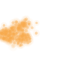

-------------------------
generated stroke
discriminator prediction for true = 0: 0.022


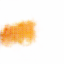

--------------------------------------------------
Epoch 2/5 | Sample 351/391
 => Loss: 1) discriminator - 0.488, 2) generator - 1.803
true stroke
discriminator prediction for true = 1: 0.933


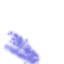

-------------------------
generated stroke
discriminator prediction for true = 0: 0.043


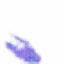

--------------------------------------------------
Epoch 2/5 | Sample 376/391
 => Loss: 1) discriminator - 0.486, 2) generator - 1.805
true stroke
discriminator prediction for true = 1: 0.978


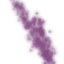

-------------------------
generated stroke
discriminator prediction for true = 0: 0.032


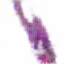

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 2/5 - time: 485.751, => Loss of generator: 1.807
Epoch 3/5 | Sample 1/391
 => Loss: 1) discriminator - 0.484, 2) generator - 1.807
true stroke
discriminator prediction for true = 1: 0.816


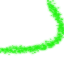

-------------------------
generated stroke
discriminator prediction for true = 0: 0.101


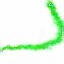

--------------------------------------------------
Epoch 3/5 | Sample 26/391
 => Loss: 1) discriminator - 0.481, 2) generator - 1.809
true stroke
discriminator prediction for true = 1: 0.889


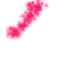

-------------------------
generated stroke
discriminator prediction for true = 0: 0.184


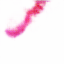

--------------------------------------------------
Epoch 3/5 | Sample 51/391
 => Loss: 1) discriminator - 0.479, 2) generator - 1.811
true stroke
discriminator prediction for true = 1: 0.16


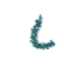

-------------------------
generated stroke
discriminator prediction for true = 0: 0.594


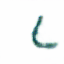

--------------------------------------------------
Epoch 3/5 | Sample 76/391
 => Loss: 1) discriminator - 0.477, 2) generator - 1.817
true stroke
discriminator prediction for true = 1: 0.368


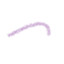

-------------------------
generated stroke
discriminator prediction for true = 0: 0.352


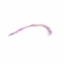

--------------------------------------------------
Epoch 3/5 | Sample 101/391
 => Loss: 1) discriminator - 0.475, 2) generator - 1.820
true stroke
discriminator prediction for true = 1: 0.952


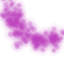

-------------------------
generated stroke
discriminator prediction for true = 0: 0.103


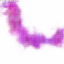

--------------------------------------------------
Epoch 3/5 | Sample 126/391
 => Loss: 1) discriminator - 0.473, 2) generator - 1.823
true stroke
discriminator prediction for true = 1: 0.47


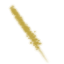

-------------------------
generated stroke
discriminator prediction for true = 0: 0.779


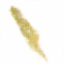

--------------------------------------------------
Epoch 3/5 | Sample 151/391
 => Loss: 1) discriminator - 0.471, 2) generator - 1.826
true stroke
discriminator prediction for true = 1: 0.885


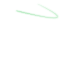

-------------------------
generated stroke
discriminator prediction for true = 0: 0.121


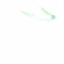

--------------------------------------------------
Epoch 3/5 | Sample 176/391
 => Loss: 1) discriminator - 0.468, 2) generator - 1.829
true stroke
discriminator prediction for true = 1: 0.459


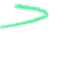

-------------------------
generated stroke
discriminator prediction for true = 0: 0.066


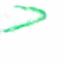

--------------------------------------------------
Epoch 3/5 | Sample 201/391
 => Loss: 1) discriminator - 0.466, 2) generator - 1.833
true stroke
discriminator prediction for true = 1: 0.353


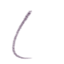

-------------------------
generated stroke
discriminator prediction for true = 0: 0.073


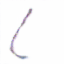

--------------------------------------------------
Epoch 3/5 | Sample 226/391
 => Loss: 1) discriminator - 0.464, 2) generator - 1.837
true stroke
discriminator prediction for true = 1: 0.497


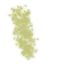

-------------------------
generated stroke
discriminator prediction for true = 0: 0.353


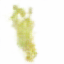

--------------------------------------------------
Epoch 3/5 | Sample 251/391
 => Loss: 1) discriminator - 0.461, 2) generator - 1.841
true stroke
discriminator prediction for true = 1: 0.921


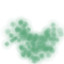

-------------------------
generated stroke
discriminator prediction for true = 0: 0.013


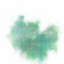

--------------------------------------------------
Epoch 3/5 | Sample 276/391
 => Loss: 1) discriminator - 0.460, 2) generator - 1.846
true stroke
discriminator prediction for true = 1: 0.856


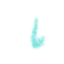

-------------------------
generated stroke
discriminator prediction for true = 0: 0.325


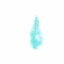

--------------------------------------------------
Epoch 3/5 | Sample 301/391
 => Loss: 1) discriminator - 0.458, 2) generator - 1.850
true stroke
discriminator prediction for true = 1: 0.944


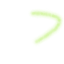

-------------------------
generated stroke
discriminator prediction for true = 0: 0.037


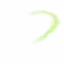

--------------------------------------------------
Epoch 3/5 | Sample 326/391
 => Loss: 1) discriminator - 0.456, 2) generator - 1.852
true stroke
discriminator prediction for true = 1: 0.761


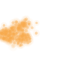

-------------------------
generated stroke
discriminator prediction for true = 0: 0.015


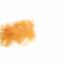

--------------------------------------------------
Epoch 3/5 | Sample 351/391
 => Loss: 1) discriminator - 0.454, 2) generator - 1.855
true stroke
discriminator prediction for true = 1: 0.526


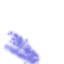

-------------------------
generated stroke
discriminator prediction for true = 0: 0.162


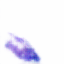

--------------------------------------------------
Epoch 3/5 | Sample 376/391
 => Loss: 1) discriminator - 0.452, 2) generator - 1.859
true stroke
discriminator prediction for true = 1: 0.919


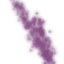

-------------------------
generated stroke
discriminator prediction for true = 0: 0.014


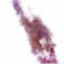

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 3/5 - time: 485.763, => Loss of generator: 1.861
Epoch 4/5 | Sample 1/391
 => Loss: 1) discriminator - 0.451, 2) generator - 1.861
true stroke
discriminator prediction for true = 1: 0.821


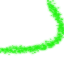

-------------------------
generated stroke
discriminator prediction for true = 0: 0.027


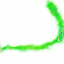

--------------------------------------------------
Epoch 4/5 | Sample 26/391
 => Loss: 1) discriminator - 0.449, 2) generator - 1.865
true stroke
discriminator prediction for true = 1: 0.957


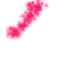

-------------------------
generated stroke
discriminator prediction for true = 0: 0.119


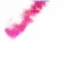

--------------------------------------------------
Epoch 4/5 | Sample 51/391
 => Loss: 1) discriminator - 0.447, 2) generator - 1.869
true stroke
discriminator prediction for true = 1: 0.807


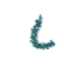

-------------------------
generated stroke
discriminator prediction for true = 0: 0.023


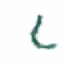

--------------------------------------------------
Epoch 4/5 | Sample 76/391
 => Loss: 1) discriminator - 0.446, 2) generator - 1.872
true stroke
discriminator prediction for true = 1: 0.947


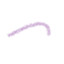

-------------------------
generated stroke
discriminator prediction for true = 0: 0.099


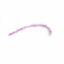

--------------------------------------------------
Epoch 4/5 | Sample 101/391
 => Loss: 1) discriminator - 0.444, 2) generator - 1.876
true stroke
discriminator prediction for true = 1: 0.899


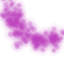

-------------------------
generated stroke
discriminator prediction for true = 0: 0.067


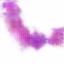

--------------------------------------------------
Epoch 4/5 | Sample 126/391
 => Loss: 1) discriminator - 0.442, 2) generator - 1.880
true stroke
discriminator prediction for true = 1: 0.36


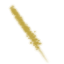

-------------------------
generated stroke
discriminator prediction for true = 0: 0.809


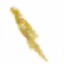

--------------------------------------------------
Epoch 4/5 | Sample 151/391
 => Loss: 1) discriminator - 0.441, 2) generator - 1.883
true stroke
discriminator prediction for true = 1: 0.834


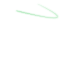

-------------------------
generated stroke
discriminator prediction for true = 0: 0.323


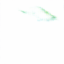

--------------------------------------------------
Epoch 4/5 | Sample 176/391
 => Loss: 1) discriminator - 0.439, 2) generator - 1.887
true stroke
discriminator prediction for true = 1: 0.764


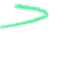

-------------------------
generated stroke
discriminator prediction for true = 0: 0.277


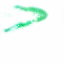

--------------------------------------------------
Epoch 4/5 | Sample 201/391
 => Loss: 1) discriminator - 0.437, 2) generator - 1.891
true stroke
discriminator prediction for true = 1: 0.71


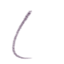

-------------------------
generated stroke
discriminator prediction for true = 0: 0.011


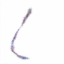

--------------------------------------------------
Epoch 4/5 | Sample 226/391
 => Loss: 1) discriminator - 0.436, 2) generator - 1.894
true stroke
discriminator prediction for true = 1: 0.721


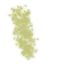

-------------------------
generated stroke
discriminator prediction for true = 0: 0.056


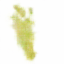

--------------------------------------------------
Epoch 4/5 | Sample 251/391
 => Loss: 1) discriminator - 0.434, 2) generator - 1.898
true stroke
discriminator prediction for true = 1: 0.74


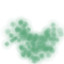

-------------------------
generated stroke
discriminator prediction for true = 0: 0.005


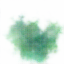

--------------------------------------------------
Epoch 4/5 | Sample 276/391
 => Loss: 1) discriminator - 0.433, 2) generator - 1.902
true stroke
discriminator prediction for true = 1: 0.922


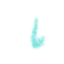

-------------------------
generated stroke
discriminator prediction for true = 0: 0.207


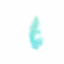

--------------------------------------------------
Epoch 4/5 | Sample 301/391
 => Loss: 1) discriminator - 0.431, 2) generator - 1.906
true stroke
discriminator prediction for true = 1: 0.906


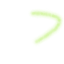

-------------------------
generated stroke
discriminator prediction for true = 0: 0.015


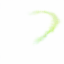

--------------------------------------------------
Epoch 4/5 | Sample 326/391
 => Loss: 1) discriminator - 0.430, 2) generator - 1.909
true stroke
discriminator prediction for true = 1: 0.522


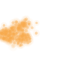

-------------------------
generated stroke
discriminator prediction for true = 0: 0.382


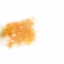

--------------------------------------------------
Epoch 4/5 | Sample 351/391
 => Loss: 1) discriminator - 0.428, 2) generator - 1.914
true stroke
discriminator prediction for true = 1: 0.943


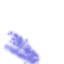

-------------------------
generated stroke
discriminator prediction for true = 0: 0.201


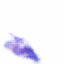

--------------------------------------------------
Epoch 4/5 | Sample 376/391
 => Loss: 1) discriminator - 0.427, 2) generator - 1.917
true stroke
discriminator prediction for true = 1: 0.952


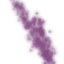

-------------------------
generated stroke
discriminator prediction for true = 0: 0.066


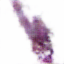

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 4/5 - time: 485.478, => Loss of generator: 1.920
Epoch 5/5 | Sample 1/391
 => Loss: 1) discriminator - 0.426, 2) generator - 1.920
true stroke
discriminator prediction for true = 1: 0.664


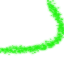

-------------------------
generated stroke
discriminator prediction for true = 0: 0.131


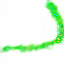

--------------------------------------------------
Epoch 5/5 | Sample 26/391
 => Loss: 1) discriminator - 0.424, 2) generator - 1.923
true stroke
discriminator prediction for true = 1: 0.886


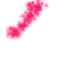

-------------------------
generated stroke
discriminator prediction for true = 0: 0.135


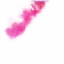

--------------------------------------------------
Epoch 5/5 | Sample 51/391
 => Loss: 1) discriminator - 0.423, 2) generator - 1.926
true stroke
discriminator prediction for true = 1: 0.429


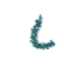

-------------------------
generated stroke
discriminator prediction for true = 0: 0.517


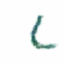

--------------------------------------------------
Epoch 5/5 | Sample 76/391
 => Loss: 1) discriminator - 0.422, 2) generator - 1.929
true stroke
discriminator prediction for true = 1: 0.434


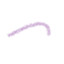

-------------------------
generated stroke
discriminator prediction for true = 0: 0.804


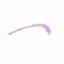

--------------------------------------------------
Epoch 5/5 | Sample 101/391
 => Loss: 1) discriminator - 0.420, 2) generator - 1.933
true stroke
discriminator prediction for true = 1: 0.988


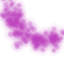

-------------------------
generated stroke
discriminator prediction for true = 0: 0.019


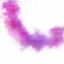

--------------------------------------------------
Epoch 5/5 | Sample 126/391
 => Loss: 1) discriminator - 0.419, 2) generator - 1.937
true stroke
discriminator prediction for true = 1: 0.649


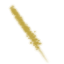

-------------------------
generated stroke
discriminator prediction for true = 0: 0.062


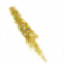

--------------------------------------------------
Epoch 5/5 | Sample 151/391
 => Loss: 1) discriminator - 0.418, 2) generator - 1.940
true stroke
discriminator prediction for true = 1: 0.797


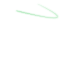

-------------------------
generated stroke
discriminator prediction for true = 0: 0.299


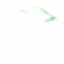

--------------------------------------------------
Epoch 5/5 | Sample 176/391
 => Loss: 1) discriminator - 0.416, 2) generator - 1.943
true stroke
discriminator prediction for true = 1: 0.776


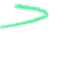

-------------------------
generated stroke
discriminator prediction for true = 0: 0.051


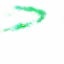

--------------------------------------------------
Epoch 5/5 | Sample 201/391
 => Loss: 1) discriminator - 0.415, 2) generator - 1.946
true stroke
discriminator prediction for true = 1: 0.964


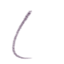

-------------------------
generated stroke
discriminator prediction for true = 0: 0.097


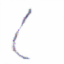

--------------------------------------------------
Epoch 5/5 | Sample 226/391
 => Loss: 1) discriminator - 0.414, 2) generator - 1.949
true stroke
discriminator prediction for true = 1: 0.724


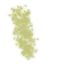

-------------------------
generated stroke
discriminator prediction for true = 0: 0.174


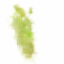

--------------------------------------------------
Epoch 5/5 | Sample 251/391
 => Loss: 1) discriminator - 0.413, 2) generator - 1.952
true stroke
discriminator prediction for true = 1: 0.92


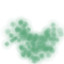

-------------------------
generated stroke
discriminator prediction for true = 0: 0.008


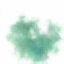

--------------------------------------------------
Epoch 5/5 | Sample 276/391
 => Loss: 1) discriminator - 0.411, 2) generator - 1.956
true stroke
discriminator prediction for true = 1: 0.885


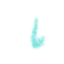

-------------------------
generated stroke
discriminator prediction for true = 0: 0.016


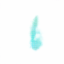

--------------------------------------------------
Epoch 5/5 | Sample 301/391
 => Loss: 1) discriminator - 0.411, 2) generator - 1.959
true stroke
discriminator prediction for true = 1: 0.866


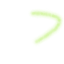

-------------------------
generated stroke
discriminator prediction for true = 0: 0.131


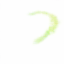

--------------------------------------------------
Epoch 5/5 | Sample 326/391
 => Loss: 1) discriminator - 0.410, 2) generator - 1.963
true stroke
discriminator prediction for true = 1: 0.878


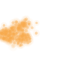

-------------------------
generated stroke
discriminator prediction for true = 0: 0.032


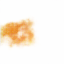

--------------------------------------------------
Epoch 5/5 | Sample 351/391
 => Loss: 1) discriminator - 0.408, 2) generator - 1.967
true stroke
discriminator prediction for true = 1: 0.901


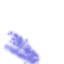

-------------------------
generated stroke
discriminator prediction for true = 0: 0.099


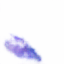

--------------------------------------------------
Epoch 5/5 | Sample 376/391
 => Loss: 1) discriminator - 0.407, 2) generator - 1.970
true stroke
discriminator prediction for true = 1: 0.918


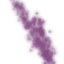

-------------------------
generated stroke
discriminator prediction for true = 0: 0.124


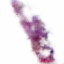

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 5/5 - time: 483.987, => Loss of generator: 1.972


In [32]:
torch.manual_seed(4)
class Hparams():
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    layers_weights = [5, 15, 2] #@param
    batch_size = 256 #@param {type: "slider", min:8, max:512, step:8}
    lr = 0.0001 #@param {type:"number"}
    betas = (0.5, 0.9) #@param
    epochs = 5 #@param {type:"slider", min:1, max:1000, step:1}
    print_interval = 25 #@param {type:"slider", min:1, max:100, step:10}
hparams = Hparams()

current_npz = 'episodes_2.npz'

strokes, actions = load_data(current_npz)

strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in strokes])
actions = torch.stack([torch.from_numpy(action).float() for action in actions])

dataset = TensorDataset(strokes, actions)

dataloader = DataLoader(dataset, 
                        batch_size = hparams.batch_size, 
                        shuffle = False)

generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

discriminator = Discriminator(hparams.img_channels, 
                              hparams.img_height)

common_path = "./results/"
generator_path = "generator_5152w_10e_1d.pth"
discriminator_path = "discriminator_10e.pth"

gpu = torch.cuda.is_available()
if gpu:
    print("Training is performed using GPU.\n")
    device = 'cuda'
else:
    print("Training is performed using CPU.\n")
    device = 'cpu'

feature_extractor = FeatureExtractor(hparams.layers_weights, device)

generator.load_state_dict(torch.load(common_path + generator_path, 
                                     map_location = torch.device(device)))
discriminator.load_state_dict(torch.load(common_path + discriminator_path, 
                                     map_location = torch.device(device)))

generator.to(device)
discriminator.to(device)

g_optimizer = optim.Adam(generator.parameters(), 
                       lr = hparams.lr, 
                       betas = hparams.betas)

d_optimizer = optim.Adam(discriminator.parameters(), 
                       lr = hparams.lr, 
                       betas = hparams.betas)

loss = F.binary_cross_entropy

trainer = Trainer(strokes_tfms,
                  generator,
                  feature_extractor,
                  discriminator,
                  g_optimizer,
                  d_optimizer,
                  loss,
                  epochs = hparams.epochs,
                  gpu = gpu)

trainer.train(dataloader, 
              print_interval = hparams.print_interval)